The Twitter API
===============

- what is an API?
- get access to the Twitter API
- use a client: [DocNow/twarc](https://github.com/docnow/twarc)
- tweets, user timelines, followers, trends
- text statistics, language, sentiment


## What is an API?

The [Application Programming
Interface](https://en.wikipedia.org/wiki/API) (API) allows computer
programs to interact with software libraries (the [pandas API](https://pandas.pydata.org/pandas-docs/stable/reference/index.html)) or services (eg. Twitter
or Mediawiki) in a similar way a [user
interface](https://en.wikipedia.org/wiki/User_interface) allows humans
to interact with computers.

## Why social media and why [Twitter](https://twitter.com/)?

Social media is an important data source for social science research:

> social media platforms are, in one sense, vast collections of
  freely available unscripted opinions, experiences and insights on
  any number of topics“ (Phillip D. Brooker
  [#1](#brooker-python-social-scientists))

The [Twitter API](https://twitter.com/TwitterAPI) is easy to set up
and usage is less restrictive compared to the APIs of other social
media platforms.

## Get Access to the Twitter API

Before [apply for access](https://developer.twitter.com/en/apply-for-access) you definitely should read about the [restrictions](https://developer.twitter.com/en/developer-terms/more-on-restricted-use-cases) on using and sharing Twitter data. You may also start browsing the [API documentation](https://developer.twitter.com/en/docs).

After having registered for an API account, you need to follow the documentation about [getting started](https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api).

Note that

- the registration and setup process requires some time
- the examples given below can only replayed if you have registered for the Twitter API

## Install and Setup Twarc

[Twarc](https://github.com/DocNow/twarc) is

> a command line tool and Python library for archiving Twitter JSON data. Each tweet is represented as a JSON object that is exactly what was returned from the Twitter API. Tweets are stored as line-oriented JSON. twarc will handle Twitter API's rate limits for you. In addition to letting you collect tweets twarc can also help you collect users, trends and hydrate tweet ids. (from the [Twarc documentation](https://twarc-project.readthedocs.io/en/latest/))

Installation and setup is done in just two steps:

- install 
  ```
  pip install twarc
  ```
- configure twarc to use your Twitter API credentials
  ```
  twarc configure
  ```
  or for version 2 of the API
  ```
  twarc2 configure
  ```

See the [Twarc documentation](https://twarc-project.readthedocs.io/en/latest/) for more details and also for first examples to work with Twarc.

We will use [twarc2](https://twarc-project.readthedocs.io/en/latest/twarc2/) to access version 2 of the Twitter API. We focus on the command-line tool only - there is no need to use the [Twarc API](https://twarc-project.readthedocs.io/en/latest/api/client2/) unless there are very specific requirements or using Twarc is part of a more complex data acquisition process.

First, we call `twarc2 --help` to figure out which options and commands are provided: 

In [1]:
!twarc2 --help

Usage: twarc2 [OPTIONS] COMMAND [ARGS]...

  Collect data from the Twitter V2 API.

Options:
  --consumer-key TEXT         Twitter app consumer key (aka "App Key")
  --consumer-secret TEXT      Twitter app consumer secret (aka "App Secret")
  --access-token TEXT         Twitter app access token for user
                              authentication.
  --access-token-secret TEXT  Twitter app access token secret for user
                              authentication.
  --bearer-token TEXT         Twitter app access bearer token.
  --app-auth / --user-auth    Use application authentication or user
                              authentication. Some rate limits are higher with
                              user authentication, but not all endpoints are
                              supported.  [default: app-auth]
  -l, --log TEXT
  --verbose
  --metadata / --no-metadata  Include/don't include metadata about when and
                              how data was collected.  [default: metadata]
  

... and to get the command-specific options:

In [2]:
!twarc2 timeline --help

Usage: twarc2 timeline [OPTIONS] USER_ID [OUTFILE]

  Retrieve recent tweets for the given user.

Options:
  --limit INTEGER                 Maximum number of tweets to return
  --since-id INTEGER              Match tweets sent after tweet id
  --until-id INTEGER              Match tweets sent prior to tweet id
  --exclude-retweets              Exclude retweets from timeline
  --exclude-replies               Exclude replies from timeline
  --start-time [%Y-%m-%d|%Y-%m-%dT%H:%M:%S]
                                  Match tweets created after time (ISO
                                  8601/RFC 3339), e.g.  2021-01-01T12:31:04
  --end-time [%Y-%m-%d|%Y-%m-%dT%H:%M:%S]
                                  Match tweets sent before time (ISO 8601/RFC
                                  3339)
  --use-search                    Use the search/all API endpoint which is not
                                  limited to the last 3200 tweets, but
                                  requires Academic Produ

## Analyzing Tweets from a User Timeline

For a first trial we download 500 tweets from the timeline of [@EXCInequality](https://twitter.com/EXCInequality) and save it to a file:

```
twarc2 timeline EXCInequality --limit 500 >data/twitter/timeline.EXCInequality.jsonl
```

Note that the Twitter developer terms of use do not allow to share the content of tweets. That's why not tweet data is included in this repository, or only in aggregations on the level of words. You need to apply for API access in order to replay the examples.

In [3]:
import json
import pandas as pd

def load_tweets(file):
    tweets = []
    with open(file) as stream:
        for line in stream:
            api_response = json.loads(line)
            for tweet in api_response['data']:
                tweets.append(tweet)
    return tweets

tweets = load_tweets('data/twitter/timeline.EXCInequality.jsonl')

len(tweets)

500

Let's look into the one of the tweets to understand the data structure and compare this with the [tweet object model documentation](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet).

In [4]:
#tweets[1]

Note: it's possible to load the tweets into a pandas dataframe but some cells still contain nested JSON elements:
```
df = pd.DataFrame(tweets)
```
Pandas provides [normalization routines](https://pandas.pydata.org/docs/user_guide/io.html?highlight=json_normalize#normalization) to flatten nested data.

But we will work with the JSON data directly and first extract which hashtags are frequently used in the Tweets of [@EXCInequality](https://twitter.com/EXCInequality):

In [5]:
from collections import Counter

aggregation_on = ('hashtags', 'tag')

# instead of hashtags count other items in the `entities` object:
# aggregation_on = ('annotations', 'normalized_text')
# aggregation_on = ('mentions', 'username')
# aggregation_on = ('urls', 'url')

counts = Counter()


for t in tweets:
    if 'entities' not in t:
        continue
    if aggregation_on[0] in t['entities']:
        for obj in t['entities'][aggregation_on[0]]:
            counts[obj[aggregation_on[1]]] += 1

counts.most_common()[0:20]

[('inequality', 35),
 ('UniKonstanz', 22),
 ('jobsinscience', 22),
 ('ClusterColloquium', 21),
 ('jobsinacademia', 21),
 ('COVID19', 18),
 ('PolicyPaper', 11),
 ('ThePoliticsOfInequality', 9),
 ('InequalityMagazine', 9),
 ('FunFriday', 9),
 ('Konstanz', 8),
 ('Homeoffice', 7),
 ('unikonstanz', 7),
 ('outsoon', 6),
 ('research', 5),
 ('PGS21', 4),
 ('Ungleichheit', 4),
 ('NewPublication', 4),
 ('Exzellenzcluster', 4),
 ('EqualPayDay', 4)]

### Find the Most Commonly Used Words in Tweets

In [6]:
words = Counter()

for t in tweets:
    for word in t['text'].split(' '):
        words[word] += 1

words.most_common()[0:10]

[('the', 313),
 ('of', 256),
 ('to', 230),
 ('in', 228),
 ('and', 226),
 ('RT', 199),
 ('a', 178),
 ('on', 128),
 ('for', 121),
 ('is', 103)]

Ok. This initial attempt shows that we need to skip over the most common functional words, in text processing called "stop words".

In [7]:
from stop_words import get_stop_words

stop_words = set(get_stop_words('en'))
stop_words.update(get_stop_words('de'))

def word_counts(tweets):
    words = Counter()
    for t in tweets:
        for word in t['text'].split(' '):
            word = word.lower()
            if word in stop_words:
                continue
            words[word] += 1
    return words

word_counts(tweets).most_common()[0:25]

[('rt', 199),
 ('&amp;', 81),
 ('-', 73),
 ('@unikonstanz', 55),
 ('@unikonstanz:', 52),
 ('cluster', 48),
 ('new', 45),
 ('research', 45),
 ('@excinequality', 30),
 ('talk', 29),
 ('work', 28),
 ('just', 27),
 ('us', 27),
 ('#inequality', 27),
 ('project', 26),
 ('–', 26),
 ('can', 24),
 ('one', 24),
 ('policy', 23),
 ('#unikonstanz', 23),
 ('social', 22),
 ('paper', 21),
 ('great', 21),
 ('inequality', 21),
 ('political', 20)]

... and we also need to skip mentions, hashtags, URLs and everything which does not look like a word:

In [8]:
stop_words.add('rt') # retweet

def word_counts(tweets):
    words = Counter()
    for t in tweets:
        for word in t['text'].split(' '):
            word = word.lower()
            if word in stop_words:
                continue
            if not word.isalpha(): # simply kill all non-alphabetical input
                continue
            words[word] += 1
    return words

word_counts(tweets).most_common()[0:25]

[('cluster', 48),
 ('new', 45),
 ('research', 45),
 ('talk', 29),
 ('work', 28),
 ('just', 27),
 ('us', 27),
 ('project', 26),
 ('can', 24),
 ('one', 24),
 ('policy', 23),
 ('social', 22),
 ('paper', 21),
 ('great', 21),
 ('inequality', 21),
 ('political', 20),
 ('welcome', 20),
 ('join', 20),
 ('job', 20),
 ('take', 18),
 ('looking', 18),
 ('first', 18),
 ('public', 16),
 ('politics', 16),
 ('senior', 15)]

### Words Used by the Official Twitter Accounts of German Political Parties

Let's download tweets from the official Twitter accounts of the political parties currently. We wrap the calls of Twarc into a loop in the command-line shell and limit the download to a single month and max. 50k tweets:

```shell
mkdir -p data/twitter/ppart/timeline/
for pp in CDU CSU spdde Die_Gruenen dieLinke AfD; do
    twarc2 timeline $pp \
           --start-time 2021-06-01 \
           --end-time 2021-07-01 \
           --limit 50000 \
           >data/twitter/ppart/timeline/$pp.jsonl
done
```

Then we load the data in Python and extract the word counts:

In [9]:
parties_in_bundestag = 'CDU CSU spdde Die_Gruenen dieLinke AfD'.split()

words = {}

for party in parties_in_bundestag:
    tweets = load_tweets('data/twitter/ppart/timeline/%s.jsonl' % party)
    words[party] = word_counts(tweets)
    # show some stats
    print(party, len(tweets), 'tweets')
    print('\t', word_counts(tweets).most_common()[0:3])


CDU 188 tweets
	 [('heute', 21), ('deutschland', 19), ('uhr', 13)]
CSU 179 tweets
	 [('heute', 18), ('bayern', 16), ('land', 12)]
spdde 765 tweets
	 [('heute', 72), ('sagt', 53), ('mehr', 46)]
Die_Gruenen 280 tweets
	 [('sagt', 32), ('müssen', 25), ('robert', 24)]
dieLinke 444 tweets
	 [('linke', 33), ('menschen', 28), ('soziale', 23)]
AfD 206 tweets
	 [('braucht', 14), ('mehr', 13), ('dank', 12)]


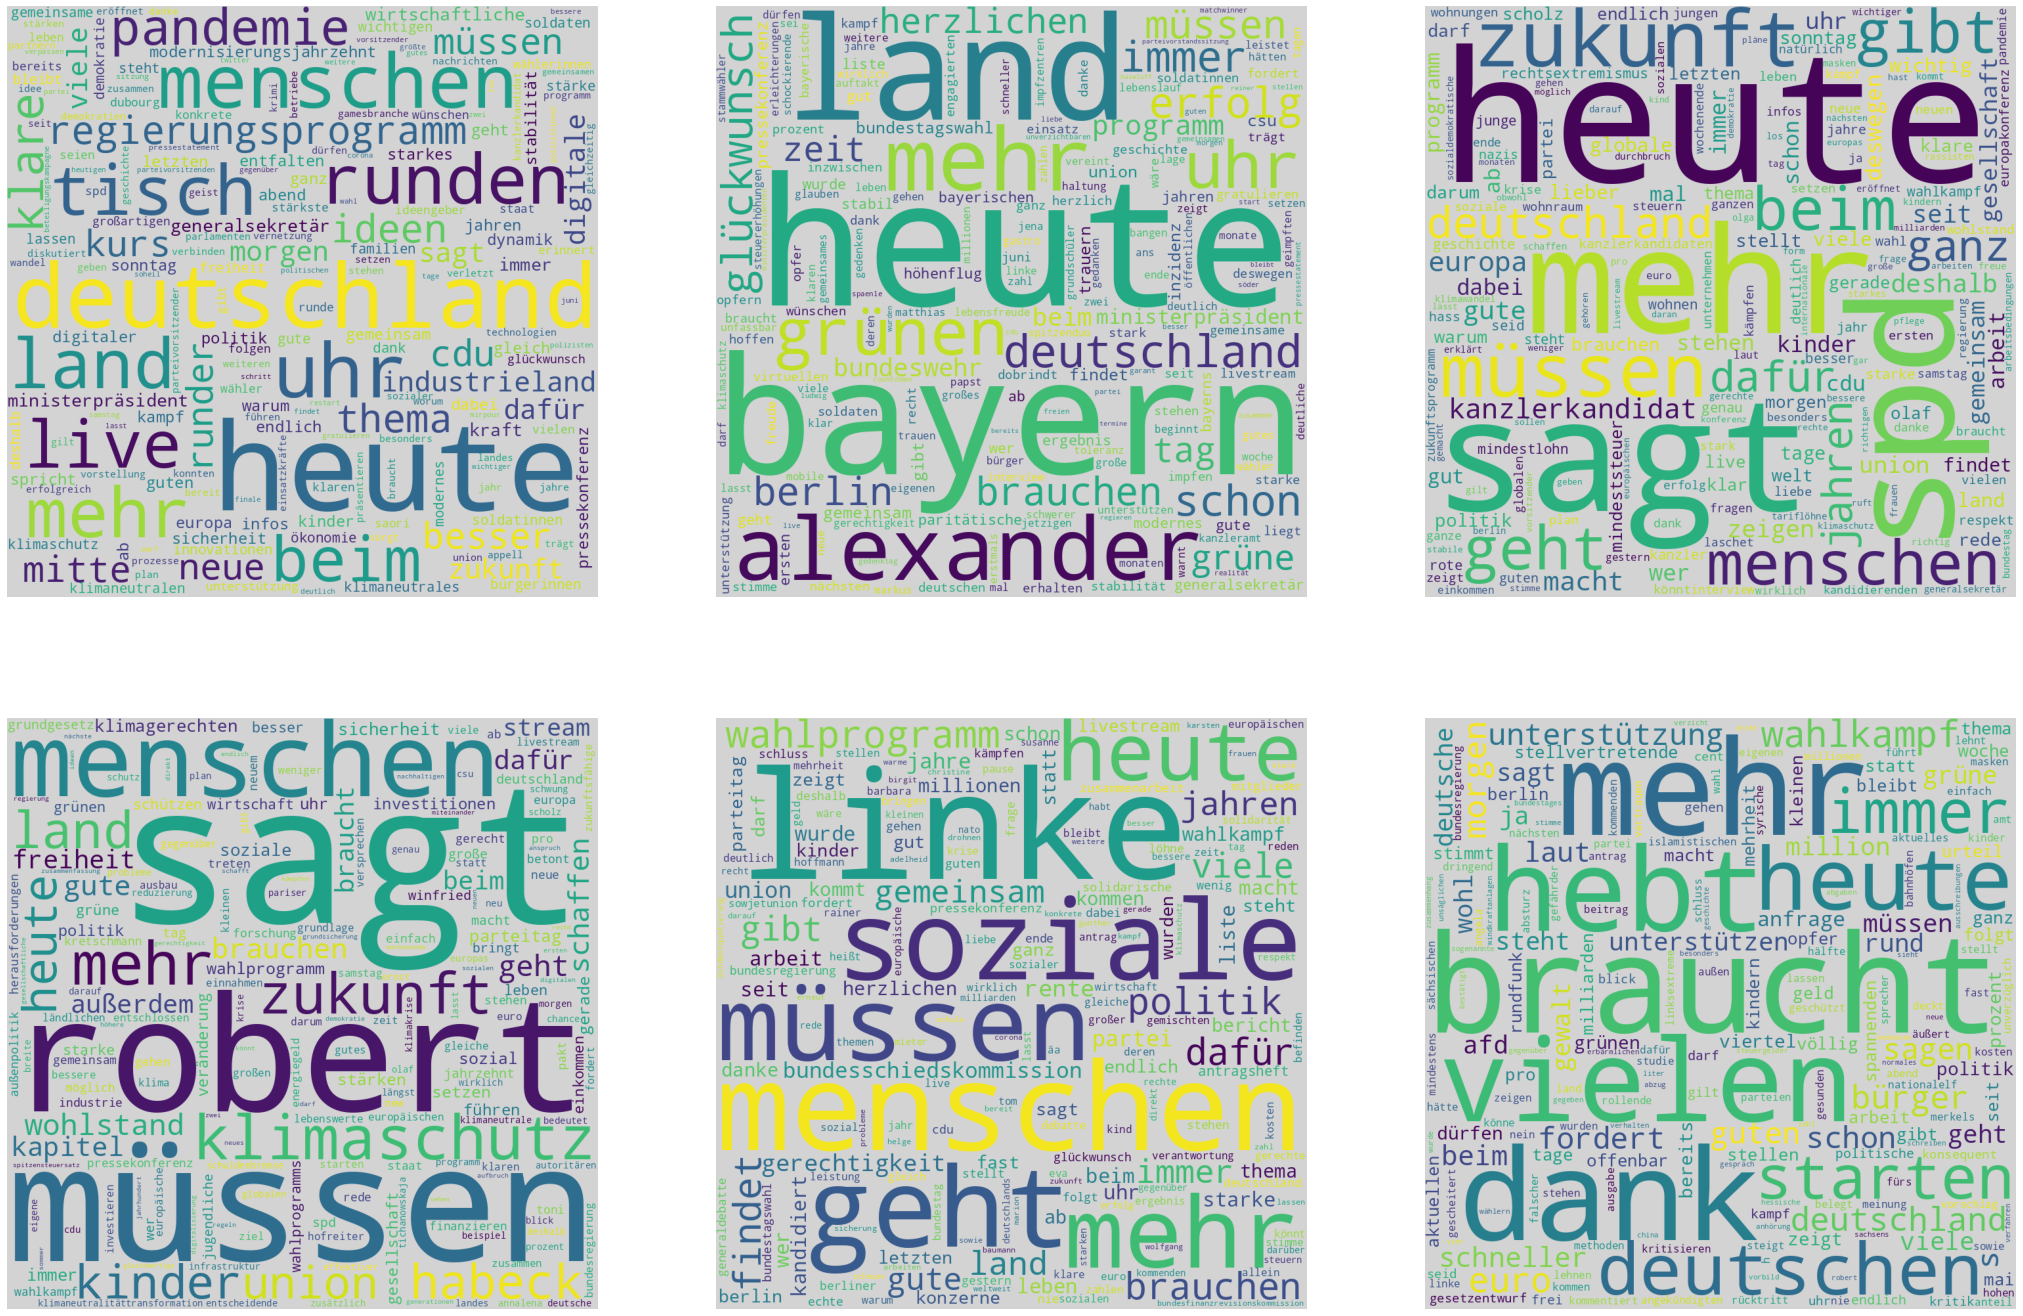

In [10]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,
                         squeeze=True, figsize=[36,24])

n = 0
for party in parties_in_bundestag:
    wordcloud = WordCloud(width=900, height=900,
                          background_color='lightgrey',
                          min_font_size=10) \
                .generate_from_frequencies(words[party])
    axis = axes[int(n/3),n%3]
    axis.imshow(wordcloud)
    axis.axis('off') # do not show x/y scale
    n += 1

plt.show()

## Links and References

- <a name="brooker-python-social-scientists"/>Phillip Brooker's book [Programming with Python for Social Scientists ](https://uk.sagepub.com/en-gb/eur/programming-with-python-for-social-scientists/book259581) includes a chapter about using the Twitter API
- https://developer.twitter.com/en/products/twitter-api
- https://twitter.com/TwitterAPI
- https://developer.twitter.com/en/use-cases/do-research
- https://developer.twitter.com/en/products/twitter-api/academic-research
- https://twarc-project.readthedocs.io/en/latest/
- https://scholarslab.github.io/learn-twarc/
- https://github.com/DocNow/twarc/tree/main/utils (for JSON data downloaded using the v1 API)
